In [192]:
import pandas as pd
import numpy as np

from sklearn.neighbors import NearestNeighbors

from matplotlib import pyplot as plt
import seaborn as sns


In [193]:
# TODO: Add total spendings column

In [194]:
# 1) FRESH: annual spending (m.u.) on fresh products (Continuous);
# 2) MILK: annual spending (m.u.) on milk products (Continuous);
# 3) GROCERY: annual spending (m.u.) on grocery products (Continuous);
# 4) FROZEN: annual spending (m.u.) on frozen products (Continuous)
# 5) DETERGENTS_PAPER: annual spending (m.u.) on detergents and paper products (Continuous)
# 6) DELICATESSEN: annual spending (m.u.) on and delicatessen products (Continuous);
# 7) CHANNEL: customers' Channel - Horeca (Hotel/Restaurant/CafÃ©) or Retail channel (Nominal)
# 8) REGION: customers' Region - Lisnon, Oporto or Other (Nominal)
# Descriptive Statistics:

# (Minimum, Maximum, Mean, Std. Deviation)
# FRESH ( 3, 112151, 12000.30, 12647.329)
# MILK (55, 73498, 5796.27, 7380.377)
# GROCERY (3, 92780, 7951.28, 9503.163)
# FROZEN (25, 60869, 3071.93, 4854.673)
# DETERGENTS_PAPER (3, 40827, 2881.49, 4767.854)
# DELICATESSEN (3, 47943, 1524.87, 2820.106)

# REGION Frequency
# Lisbon 77
# Oporto 47
# Other Region 316
# Total 440

# CHANNEL Frequency
# Horeca 298
# Retail 142
# Total 440



# 1 Loading the Data, Preprocessing, Initial Data Analysis

In [195]:
df = pd.read_csv(r"https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv")
df = df.drop(columns=["Channel", "Region"])
df_og = df.copy()
df

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185
...,...,...,...,...,...,...
435,29703,12051,16027,13135,182,2204
436,39228,1431,764,4510,93,2346
437,14531,15488,30243,437,14841,1867
438,10290,1981,2232,1038,168,2125


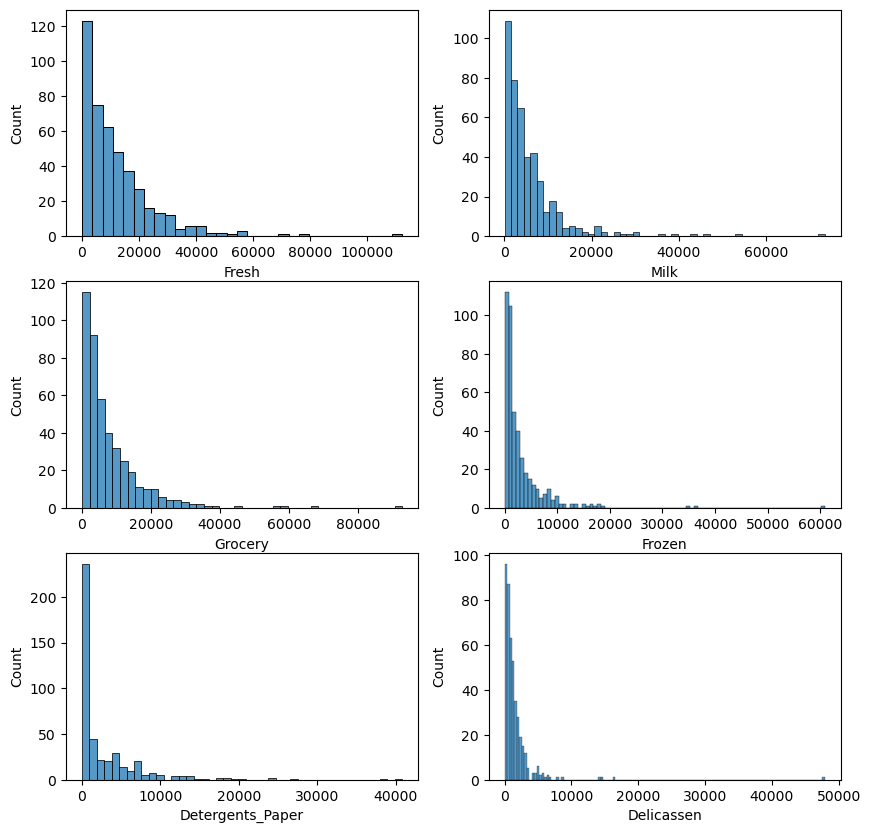

In [196]:
def plot_hist_cols():
    fig, axes = plt.subplots(3, 2, figsize=(10, 10))
    axes = axes.flatten()

    for i, col in enumerate(df.columns):
        sns.histplot(df[col], ax=axes[i])


plot_hist_cols()


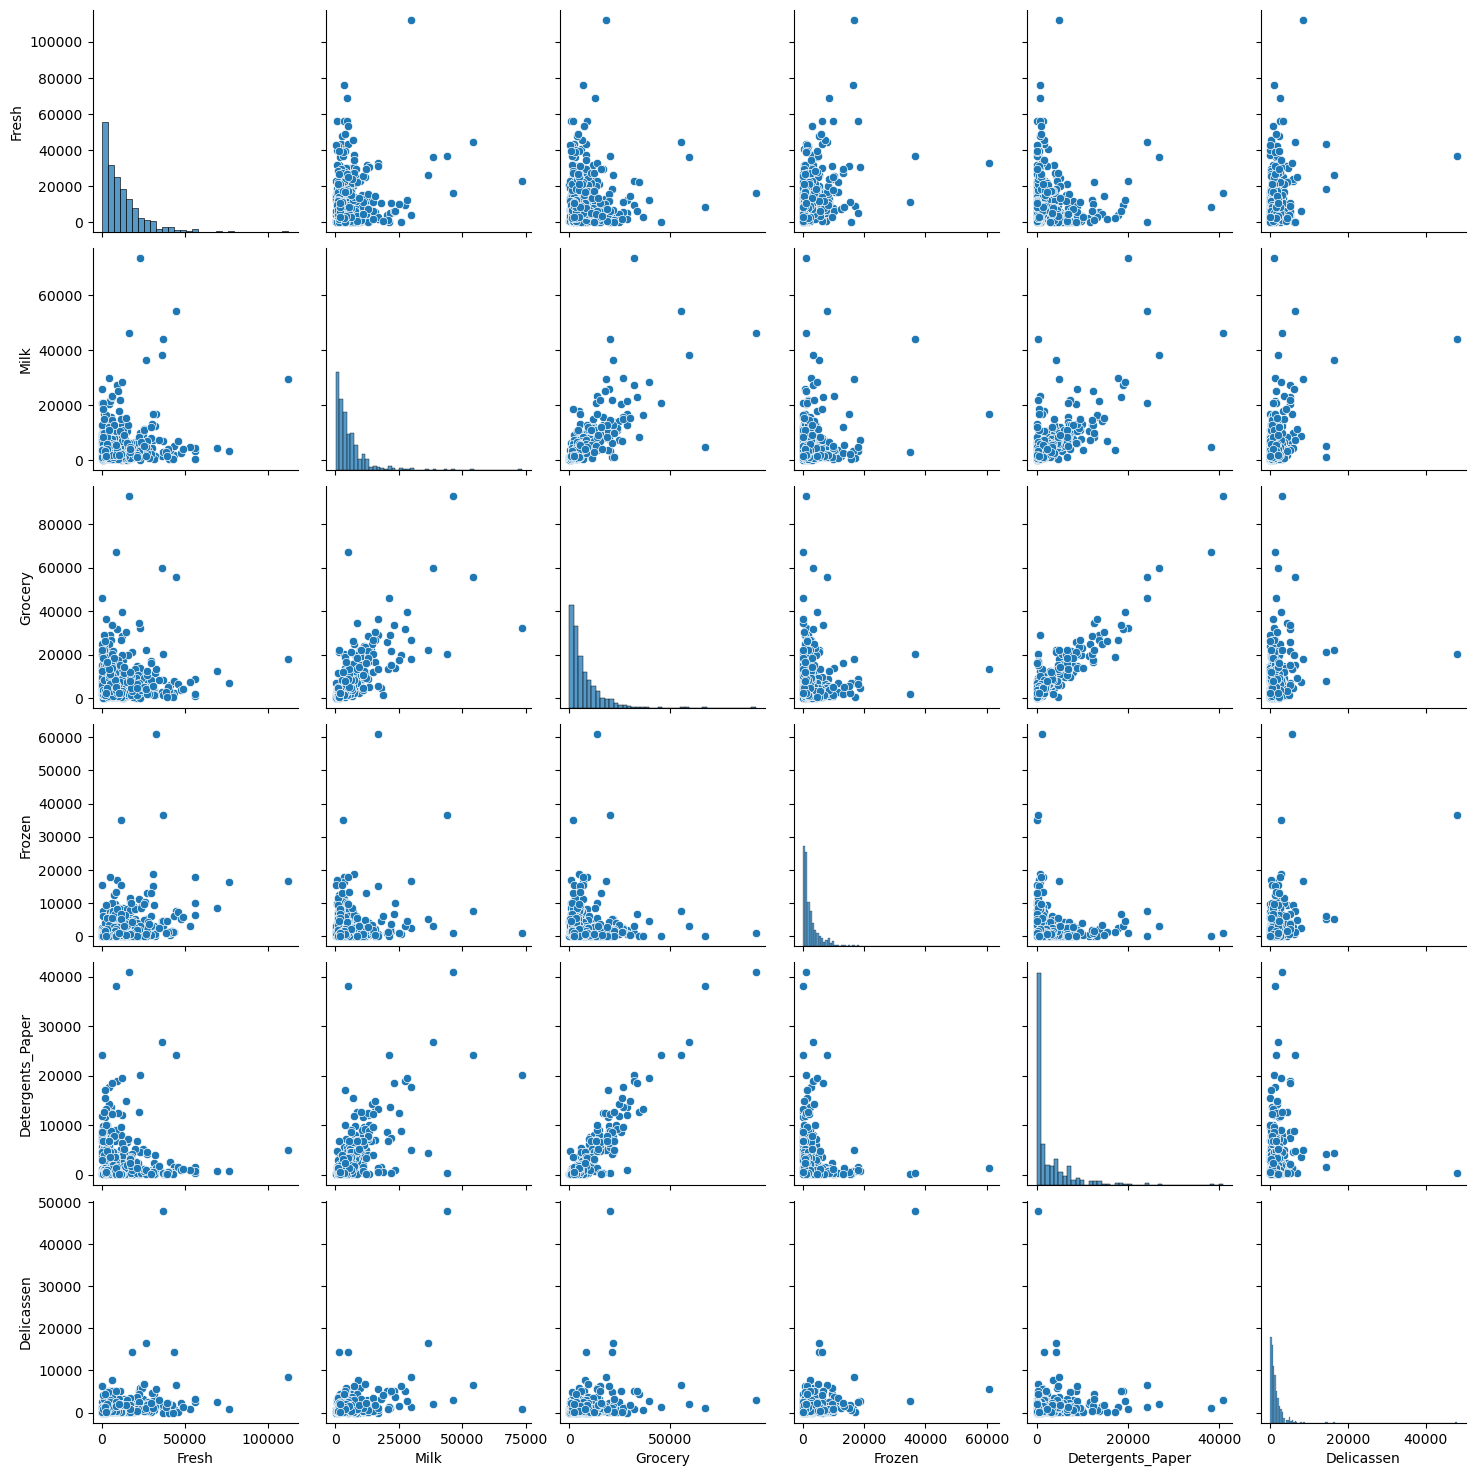

In [197]:
sns.pairplot(df)


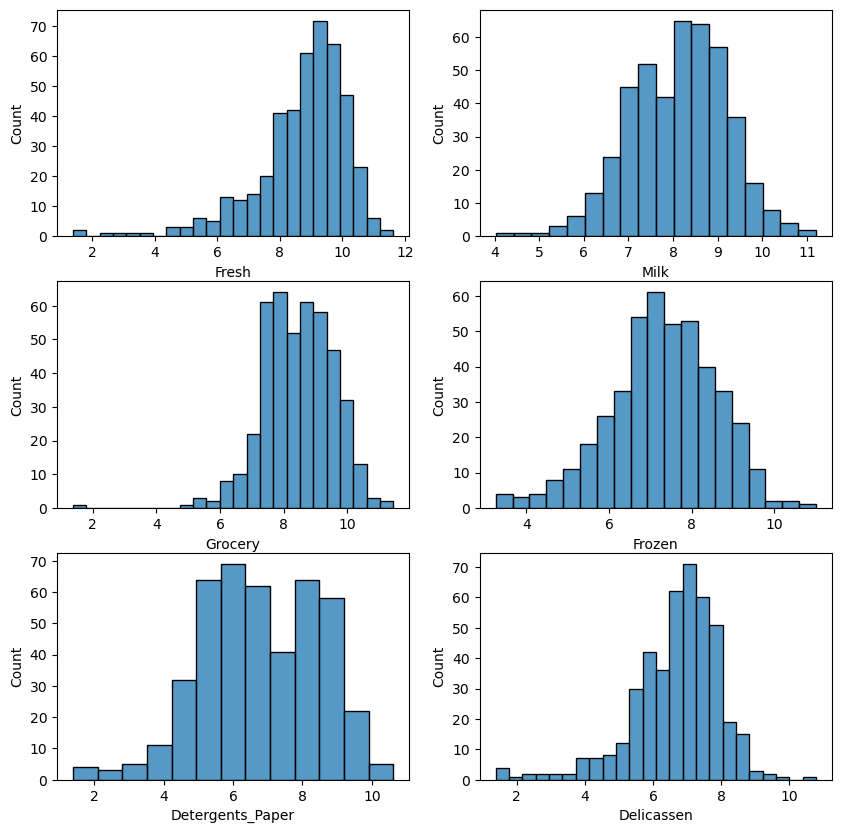

In [198]:
df = np.log(df + 1)
df_overview = df.copy()
plot_hist_cols()


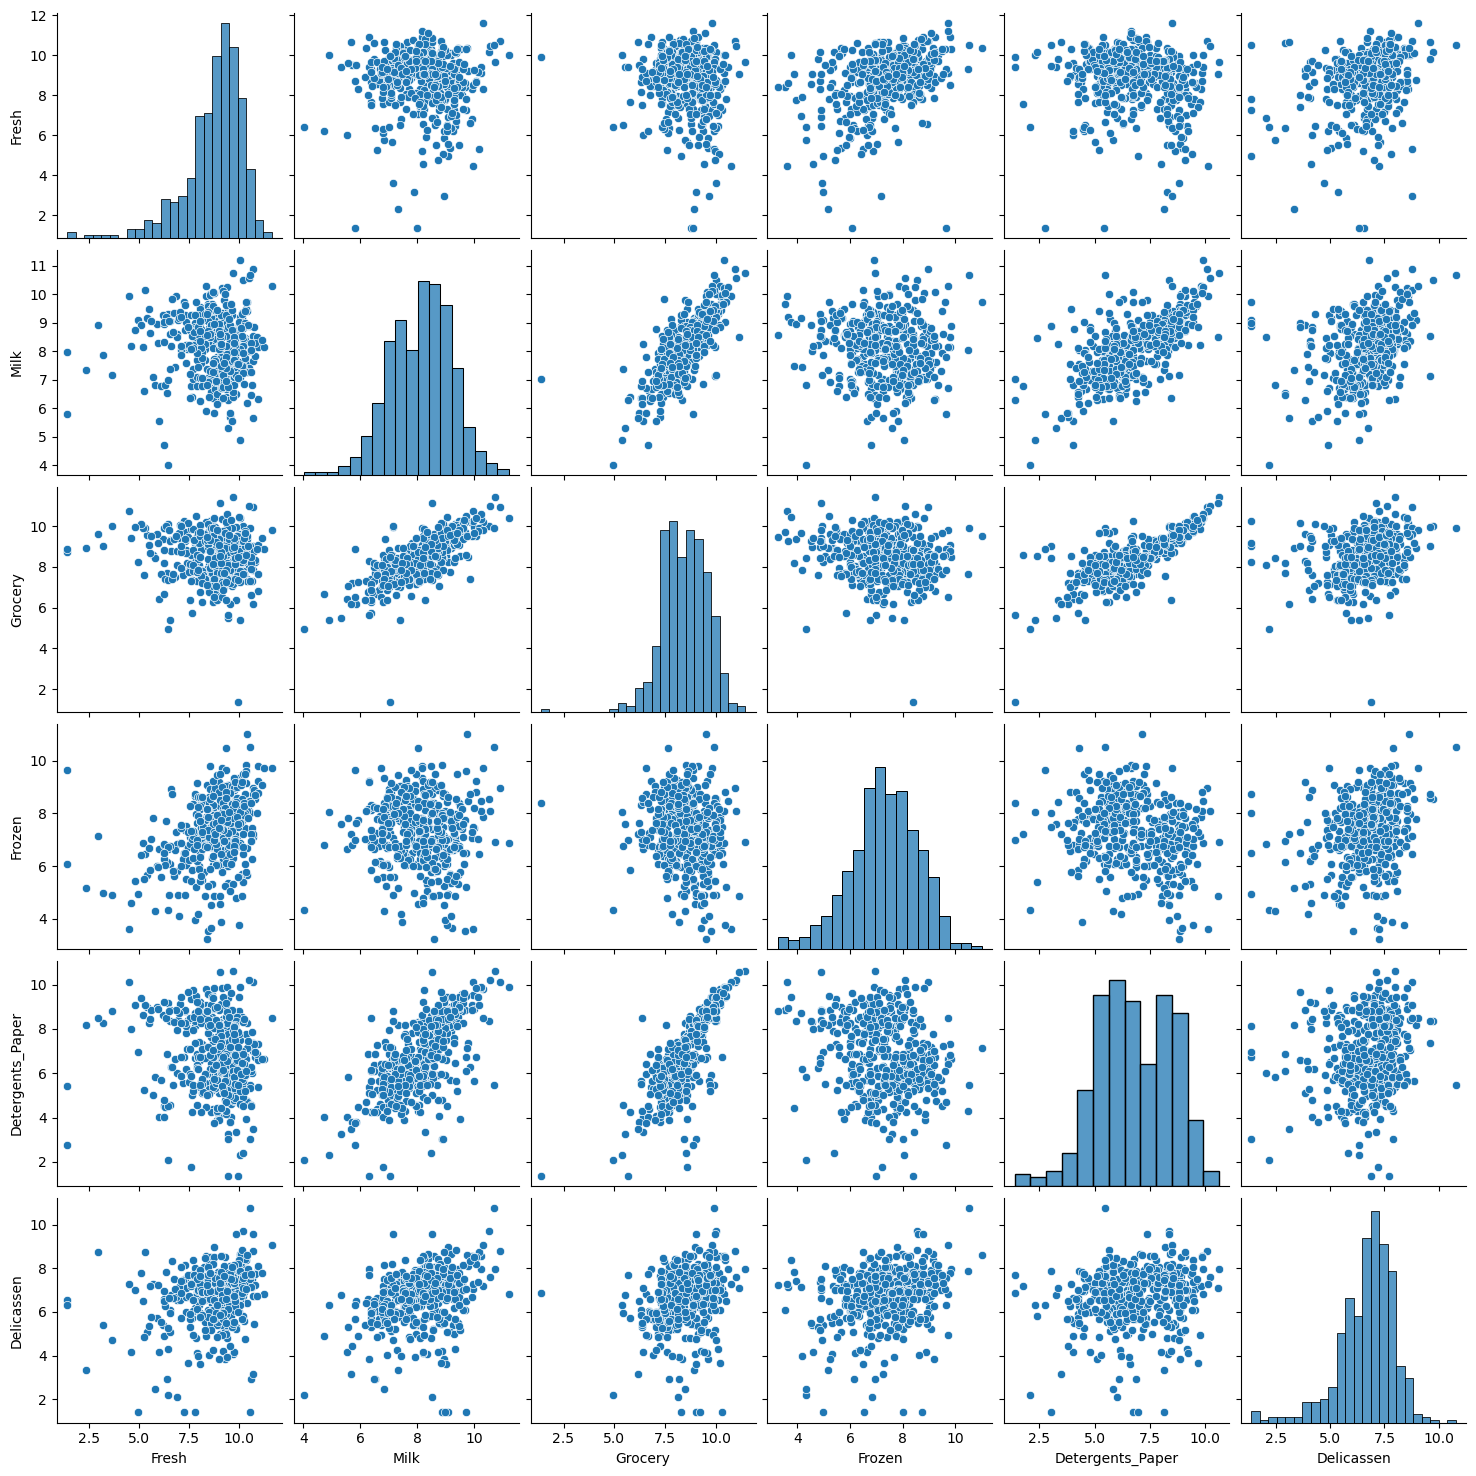

In [199]:
sns.pairplot(df)
# TODO: Add Correlation Plot and a column with total spendings
# Barplot/Pie chart with spendings from total spendings


# 2 Detecting Anomalies
## Hard-Min Score

In [200]:
nbrs = NearestNeighbors(n_neighbors=2, algorithm="ball_tree").fit(df)
distances, indices = nbrs.kneighbors(df)
df_overview["outlier_score_min"] = np.square(distances[:, 1])
df_overview.sort_values(by="outlier_score_min", ascending=False).head(10)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,outlier_score_min
338,1.386294,5.811141,8.856803,9.655154,2.772589,6.311735,24.462058
75,9.923241,7.037028,1.386294,8.391176,1.386294,6.883463,21.598732
154,6.434547,4.025352,4.927254,4.330733,2.079442,2.197225,17.656426
142,10.519673,8.875287,9.018453,8.005033,3.044522,1.386294,14.249027
95,1.386294,7.979681,8.740817,6.089045,5.411646,6.565265,14.033121
187,7.799343,8.987572,9.192176,8.743532,8.149024,1.386294,9.006401
128,4.948760,9.087947,8.249052,4.962845,6.968850,1.386294,8.841779
183,10.514557,10.690831,9.912001,10.506026,5.480639,10.777789,8.742070
204,7.579168,6.793466,8.561593,7.232733,1.791759,7.192182,8.531557
109,7.249215,9.724959,10.274603,6.513230,6.729824,1.386294,7.406475


In [201]:
print(distances.shape)
# distances: Zeile = sample, Spalte 1 = kürzeste Distanz
# Spalte 0 = alles 0
print(indices.shape)
# indices: erste Spalte 0-440; zweite Spalte: index zur kürzesten Distanz

(440, 2)
(440, 2)


In [202]:
print(distances[0, 1], indices[0])
# quick double check
np.linalg.norm(df.iloc[0, :] - df.iloc[59, :])

1.0869428312265155 [ 0 59]


1.0869428312265155

5.436841897234807


,outlier_score_min
count,440.000000
mean,1.457789
std,2.334358
min,0.075394
25%,0.551666
50%,0.804108
75%,1.354759
max,24.462058


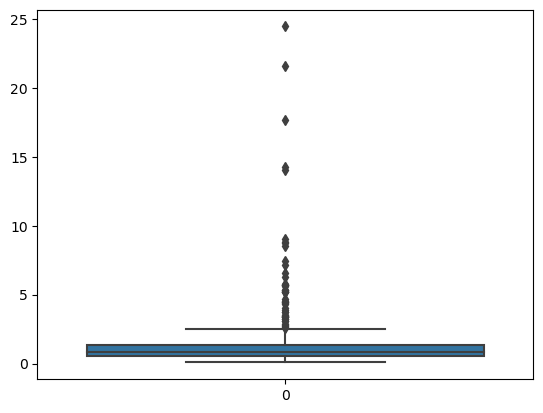

<AxesSubplot: xlabel='outlier_score_min', ylabel='Count'>

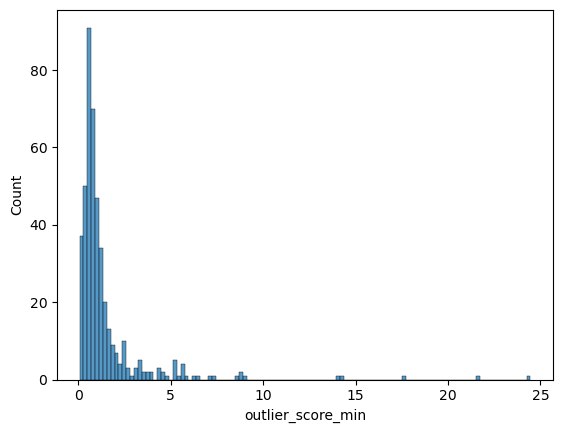

In [203]:
print(np.var(df_overview['outlier_score_min']))
display(df_overview[["outlier_score_min"]].describe())
sns.boxplot(df_overview["outlier_score_min"])
plt.show()
sns.histplot(df_overview["outlier_score_min"])
# want it to be centered/dense!

## Soft-Min Score/KDE approach

In [204]:
nbrs = NearestNeighbors(n_neighbors=len(df), algorithm="ball_tree").fit(df)
distances, indices = nbrs.kneighbors(df)
distances = np.square(distances)
gamma = 1

def softmin(z, gamma):
    # return -1 / gamma * np.log(1 / (len(z) - 1) * np.sum(np.exp(-gamma * z)))
    return -1 * np.log(1 / (len(z) - 1) * np.sum(np.exp(-gamma * z)))


df_overview["outlier_score_softmin"] = np.apply_along_axis(softmin, 1, distances[:, 1:], gamma)
df_overview.sort_values(by="outlier_score_softmin", ascending=False).head(10)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,outlier_score_min,outlier_score_softmin
338,1.386294,5.811141,8.856803,9.655154,2.772589,6.311735,24.462058,30.537021
75,9.923241,7.037028,1.386294,8.391176,1.386294,6.883463,21.598732,27.074911
154,6.434547,4.025352,4.927254,4.330733,2.079442,2.197225,17.656426,23.693326
142,10.519673,8.875287,9.018453,8.005033,3.044522,1.386294,14.249027,20.321837
95,1.386294,7.979681,8.740817,6.089045,5.411646,6.565265,14.033121,20.107723
187,7.799343,8.987572,9.192176,8.743532,8.149024,1.386294,9.006401,14.740212
183,10.514557,10.690831,9.912001,10.506026,5.480639,10.777789,8.742070,14.556361
128,4.948760,9.087947,8.249052,4.962845,6.968850,1.386294,8.841779,14.214246
204,7.579168,6.793466,8.561593,7.232733,1.791759,7.192182,8.531557,13.480020
109,7.249215,9.724959,10.274603,6.513230,6.729824,1.386294,7.406475,12.812801


In [205]:
print(distances.shape)

print(np.sum(distances == 0))
distances # aufsteigende Reihenfolge, indices enthält die zugehörigen Indices

(440, 440)
440


array([[  0.        ,   1.18144472,   1.40267552, ..., 111.51568135,
        113.26455887, 121.64970847],
       [  0.        ,   0.25717029,   0.26772051, ..., 101.91089368,
        112.5661583 , 124.61456054],
       [  0.        ,   1.30272172,   1.37017949, ..., 104.67219589,
        113.37943581, 141.95057146],
       ...,
       [  0.        ,   0.96630544,   1.53277912, ..., 144.9983284 ,
        158.75403274, 159.99341285],
       [  0.        ,   0.7812449 ,   0.78166696, ...,  74.3436262 ,
         80.65129461,  80.86853978],
       [  0.        ,   5.64116508,   6.10735844, ...,  93.45774133,
         94.64201317, 108.30074901]])

7.918142665488302


,outlier_score_softmin
count,440.000000
mean,5.586344
std,2.817123
min,3.372524
25%,4.105058
50%,4.839280
75%,5.909640
max,30.537021


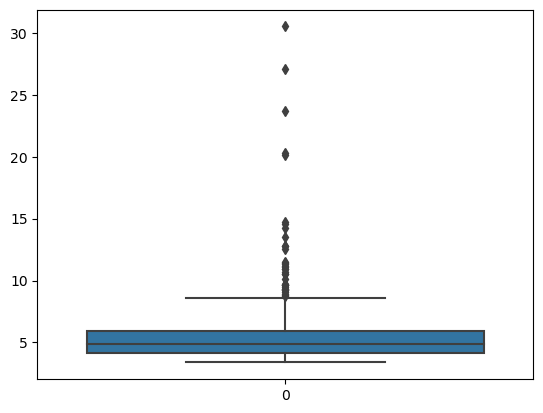

<AxesSubplot: xlabel='outlier_score_softmin', ylabel='Count'>

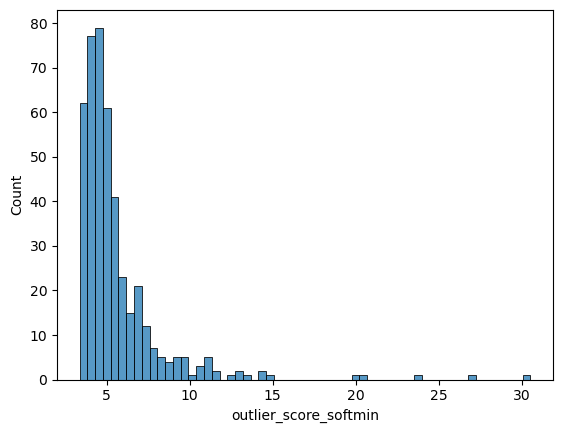

In [206]:
# TODO: Nebeneinander packe

print(np.var(df_overview['outlier_score_softmin']))
display(df_overview[["outlier_score_softmin"]].describe())
sns.boxplot(df_overview["outlier_score_softmin"])
plt.show()
sns.histplot(df_overview["outlier_score_softmin"])

Text(0, 0.5, 'softmin')

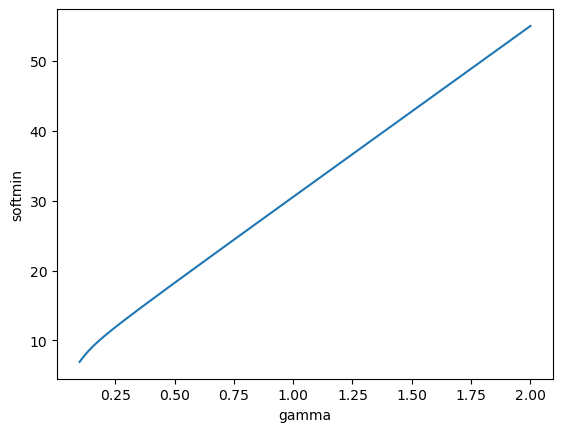

In [207]:
# visualize softmin function for a selected instance
instance = 338  # 338 has had a high outlier score
gammas = np.linspace(0.1, 2, 100)
g = sns.lineplot(
    x=gammas, y=[softmin(distances[instance, 1:], gamma) for gamma in gammas]
)
g.set_xlabel("gamma")
g.set_ylabel("softmin") 


## Bootstrap/Robustness estimate & choosing bandwidth

In [208]:
# TODO should that be the same?
# import statistics
# statistics.fmean(np.exp(-gamma * distances[0, 1:]))
# softmin(distances[instance, 1:], gamma)

hohes gamma => weniger punkte einbezogen => höhere varianz, weniger bias

niedrigeres gamma => mehr punkte einbezogen (lim => 0 all uniform) => hoher bias, low variance

need 2 measures to compare: robustness vs. value of score (how much it discriminates between outliers and "regular" points); check picture from Montavon. Visual examination/optimal point. Compare to hard min


Cluster = Partition der Daten um sie zusammenzufassen, nicht unbedingt obvious

# TEST FOR ALTERNATIVE TAKE ON EX 2

In [232]:
def softmin_og(z, gamma):
    return - (1/gamma)  * np.log(1 / (len(z) - 1) * np.sum(np.exp(-gamma * z)))

# NECESSARY TO USE ALL INSTANCES
# def clean_distances(z):
#     if z[0] == 0:
#         return z[1:]
#     else:
#         return z[0:-1]

In [233]:
N_BOOTSTRAP = 100
gamma_range = np.linspace(0.1, 2, 20)

scores = np.full((len(df), N_BOOTSTRAP, len(gamma_range)), np.nan)


for i in range(0, N_BOOTSTRAP):

    sample = df.sample(frac=0.5)

    # USE ALL INSTANCES
    # nbrs = NearestNeighbors(n_neighbors=len(sample), algorithm="ball_tree").fit(sample)
    # distances, indices = nbrs.kneighbors(df)                                                    
    # distances = np.apply_along_axis(clean_distances, 1, distances)
    # distances = np.square(distances)
    
    # for j, gamma in enumerate(gamma_range):
    #     scores[:, i, j] = np.apply_along_axis(softmin_og, 1, distances, gamma)


    # TODO all instanes or only those in sample???
    # USE ONLY IN SAMPLE
    nbrs = NearestNeighbors(n_neighbors=len(sample), algorithm="ball_tree").fit(sample)
    distances, indices = nbrs.kneighbors(sample)
    distances = np.square(distances[:, 1:])
    
    for j, gamma in enumerate(gamma_range):
        scores[sample.index, i, j] = np.apply_along_axis(softmin_og, 1, distances, gamma)



<AxesSubplot: ylabel='Count'>

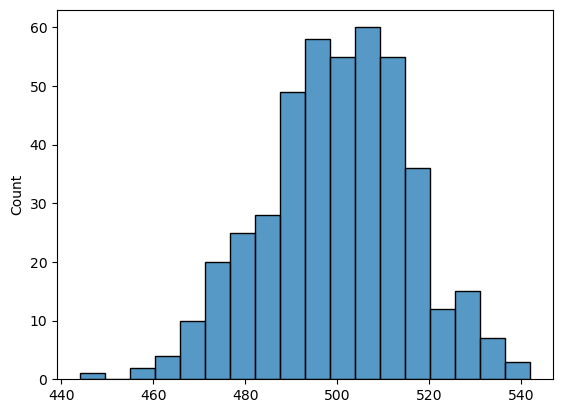

In [211]:
# check different when using all vs. only in sample
# spread = np.var(scores, axis=1)
# spread_only = np.nanvar(scores_only, axis=1)
# display(pd.DataFrame(np.linalg.norm(spread - spread_only, axis=1)).describe())

# verify normal distribution arround N_BOOTSTRAP * frac
sns.histplot(np.sum(np.isnan(scores) == False, axis=1)[:,0])

array([12.76398132, 10.50094826,  9.04152063,  8.01591113,  7.24926446,
        6.64784034,  6.15880346,  5.75070088,  5.4036843 ,  5.10450043,
        4.84383052,  4.61482055,  4.41223768,  4.23196745,  4.07070175,
        3.92573654,  3.79483463,  3.6761282 ,  3.56804691,  3.469263  ])

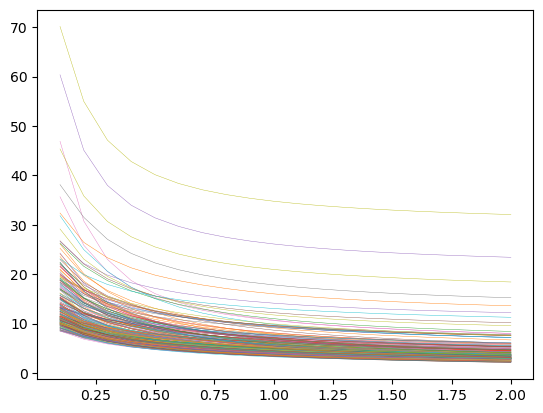

In [212]:
# instance 0, first bootstrap sample, all values for gamma
display(scores[0, 0])

# first bootstrap sample, all instances per gamma
for i in range(len(scores)):
    plt.plot(gamma_range, scores[i, 0], linewidth=0.3)
plt.show()

(440, 20)

Vars of instance 0:


array([0.13526432, 0.10037081, 0.08161892, 0.07114567, 0.06543766,
       0.06228213, 0.06038051, 0.05901342, 0.05781177, 0.05661054,
       0.05535658, 0.05405223, 0.05272263, 0.05139827, 0.05010668,
       0.0488693 , 0.04770102, 0.04661088, 0.04560328, 0.04467912])

Vars of instance 338:


array([ 6.89879905, 24.79267973, 34.1640721 , 38.73850312, 41.38506209,
       43.08846641, 44.26057133, 45.10475372, 45.73340379, 46.21376921,
       46.58850554, 46.88589435, 47.12534924, 47.32057652, 47.48148281,
       47.61537356, 47.72773099, 47.82273307, 47.90360791, 47.9728806 ])

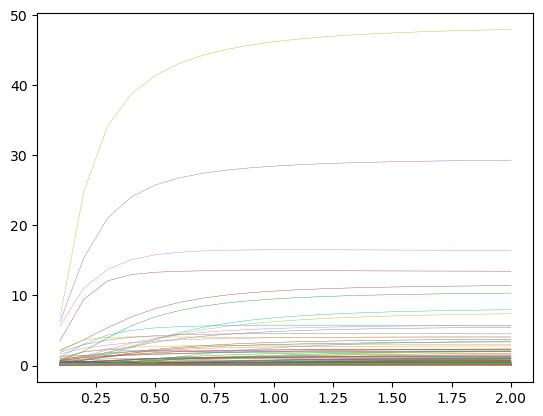

In [213]:
# calculate the spread over bootstrap dimension
spread = np.nanvar(scores, axis=1)

display(spread.shape)
print("Vars of instance 0:")
display(spread[0])

print("Vars of instance 338:")
display(spread[338])

# high values (variances) => anomaly score varied more in bootstrap samples => outlier scoring of instance is not so robust (it varies with sample)

# we want detection to be robust => so to have a low variance during bootstrap experiments

# all spreads per instances
for i in range(len(scores)):
    plt.plot(gamma_range, spread[i], linewidth=0.3)
plt.show()


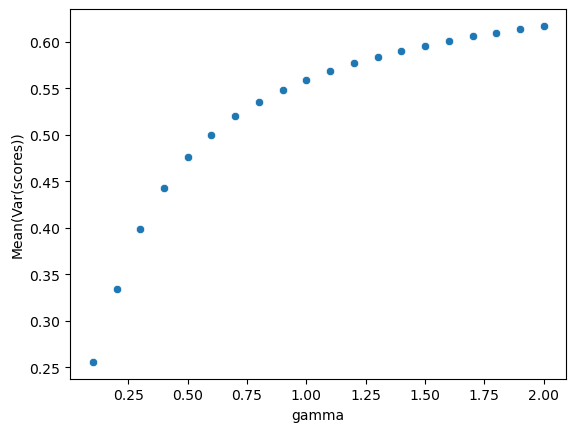

In [214]:
# gamma high => less points taken into account => on average higher variance (and less robust, right?)
g = sns.scatterplot(x=gamma_range, y=np.mean(np.nanvar(scores, axis=1), axis=0))
g.set_xlabel('gamma')
g.set_ylabel('Mean(Var(scores))')
plt.show()

(440, 20)

average outlier score of instance 0:


array([12.73983712, 10.44562926,  8.97820018,  7.95457646,  7.1954096 ,
        6.6048447 ,  6.12864734,  5.73431917,  5.40121946,  5.11551605,
        4.86749847,  4.65007958,  4.45791916,  4.28688764,  4.13372403,
        3.99580903,  3.87100938,  3.75756768,  3.65402216,  3.55914692])

average outlier score of instance 338:


array([69.49413081, 54.10958352, 46.59721973, 42.54400592, 40.04799814,
       38.36201442, 37.14747779, 36.23091543, 35.51461721, 34.93939058,
       34.4672817 , 34.07283007, 33.73831747, 33.45103312, 33.20162198,
       32.98304649, 32.78991121, 32.61801058, 32.46401819, 32.32526854])

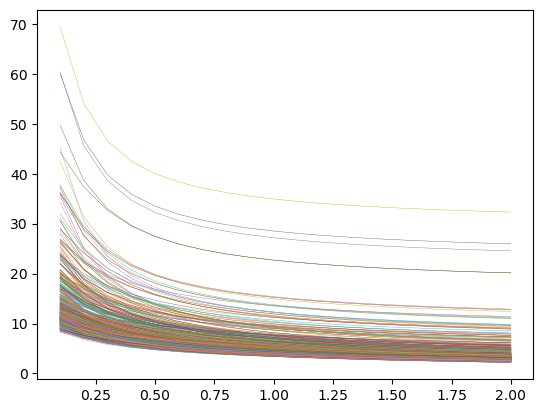

In [215]:
# average outlier score per sample, per gamma
avg_score = np.nanmean(scores, axis=1)

# TODO are the actual score values event meaningful? the range seems to depend on gamma 
# maybe the resulting ranking is more interesting?


display(avg_score.shape)
print("average outlier score of instance 0:")
display(avg_score[0])

print("average outlier score of instance 338:")
display(avg_score[338])

# high gamma => less values are taken into account => TODO seems to result in lower average outlier score (due to influence of gamma) but why?

# all avg_scores per instances
for i in range(len(scores)):
    plt.plot(gamma_range, avg_score[i], linewidth=0.3)
plt.show()


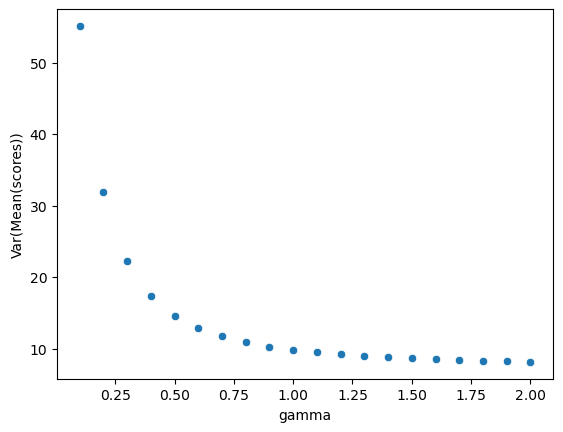

In [216]:
g = sns.scatterplot(x=gamma_range, y=np.var(np.nanmean(scores, axis=1), axis=0))
g.set_xlabel('gamma')
g.set_ylabel('Var(Mean(scores))')
plt.show()

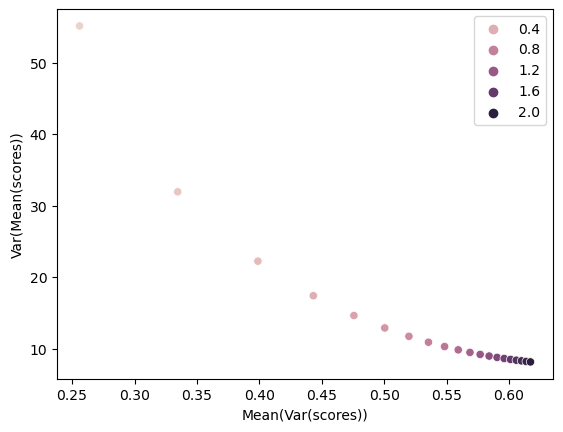

In [217]:
g = sns.scatterplot(x=np.mean(np.nanvar(scores, axis=1), axis=0), y=np.var(np.nanmean(scores, axis=1), axis=0), hue=gamma_range)
g.set_xlabel('Mean(Var(scores))')
g.set_ylabel('Var(Mean(scores))')
plt.show()

In [218]:
# TODO hard-min adden
# TODO ask about 1/gamma in softmin 

# var(mean(scores)) == discriminatory power ?
# mean(var(scores)) == model var?

# 3 Explaining Anomalies

In [219]:
def relevance(x, yj):
    # Layer-wise Relevance Propagation
    Rji = np.zeros(x.shape)
    
    for j in range(len(x)):

        mask = np.full((len(x)), True)
        mask[j] = False

        z = np.square(np.linalg.norm(x - x[j], axis = 1))
        # y = softmin_og(z[mask], gamma)

        # 1.
        temp = np.exp(-gamma * z[mask])
        Rk = temp / np.sum(temp) * yj[j]

        # 2.
        nom = np.square(x-x[j])[mask]
        denom = np.square(np.linalg.norm(x - x[j], axis = 1))[mask]

        Rji[j,:] = np.sum(nom / denom[:, None] * Rk[:, None], axis=0)

    return Rji

In [220]:
gamma = 1

# Calculate anomaly scores
nbrs = NearestNeighbors(n_neighbors=len(df), algorithm="ball_tree").fit(df)
distances, _ = nbrs.kneighbors(df)
yj = np.apply_along_axis(softmin_og, 1, np.square(distances[:, 1:]), gamma)

x = df.to_numpy()
# Layer-wise Relevance Propagation
Rji = relevance(x, yj)

# confirm conservation property
np.all(np.sum(Rji, axis=1) - yj <= 1e-14)

True

/var/folders/d7/6rwzv4n55v385stdz71392180000gn/T/ipykernel_96179/219968405.py:12: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  ax.figure.colorbar(sm)


Text(0.5, 0, 't-SNE 2')

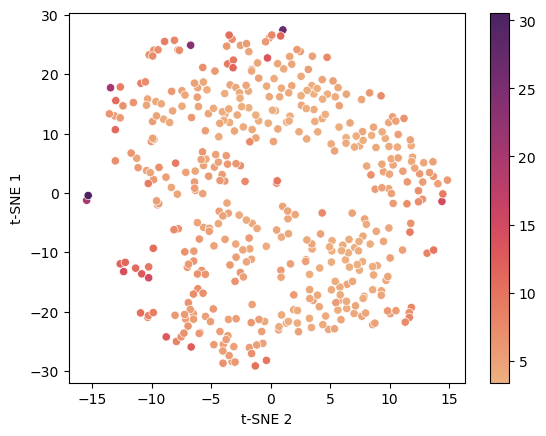

In [221]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=30).fit_transform(df)

ax = sns.scatterplot(x=X_embedded[:,1], y=X_embedded[:,0], hue=yj, palette='flare')

norm = plt.Normalize(yj.min(), yj.max())
sm = plt.cm.ScalarMappable(cmap="flare", norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.figure.colorbar(sm)

ax.set_ylabel("t-SNE 1")
ax.set_xlabel("t-SNE 2")

In [222]:
Rji[338]

array([ 0.13720415,  5.84040281,  0.01731493, 15.78557577,  8.66989822,
        0.08662472])

Fresh               1.386294
Milk                5.811141
Grocery             8.856803
Frozen              9.655154
Detergents_Paper    2.772589
Delicassen          6.311735
Name: 338, dtype: float64

(0.0, 21.410723241623632)

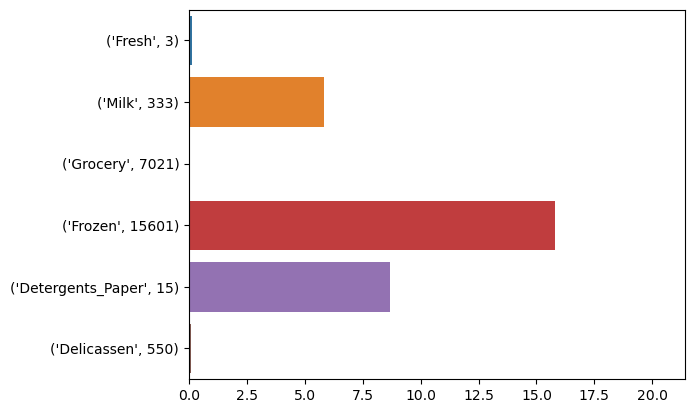

In [223]:
instance = 338
display(df.iloc[instance])
g = sns.barplot(x=Rji[instance], y=list(map(str, list(zip(df_og.iloc[instance].index, df_og.iloc[instance].values)))))
g.set_xlim(0,np.max(Rji))

In [224]:
# TODO WHY IS Fresh = 3 not relevant for outlier score?
df_og.describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


## Bootstrap test

In [225]:
gamma = 1

N_BOOTSTRAP = 100


Rji_BS = np.full((440, N_BOOTSTRAP, 6), np.nan)

for i in range(N_BOOTSTRAP):

    sample = df.sample(frac=0.5)

    nbrs = NearestNeighbors(n_neighbors=len(sample), algorithm="ball_tree").fit(sample)
    distances, _ = nbrs.kneighbors(sample)
    distances = np.square(distances[:, 1:])
    yj = np.apply_along_axis(softmin_og, 1, distances, gamma)
    
    Rji_BS[sample.index,i,:] = relevance(sample.to_numpy(), yj)

In [226]:
display(np.nanvar(Rji_BS, axis=1))
pd.DataFrame(np.mean(np.nanvar(Rji_BS, axis=1), axis=1)).describe()
# TODO what to do with that?

array([[7.13354328e-02, 2.00533465e-02, 4.20753267e-03, 1.46471094e-01,
        1.77958960e-02, 2.99241927e-02],
       [1.80665745e-02, 3.10082262e-02, 2.67117390e-03, 1.51103332e-02,
        1.44100218e-02, 3.91194502e-03],
       [5.29355888e-02, 7.01183426e-02, 5.68500889e-03, 2.73465976e-02,
        9.64340126e-03, 1.13210584e-01],
       ...,
       [5.95328806e-02, 1.34673520e-02, 3.79795568e-02, 8.19133715e-02,
        9.78460538e-02, 1.18042795e-01],
       [1.60015503e-02, 2.91768397e-02, 5.62803197e-03, 3.99903223e-02,
        6.07170372e-03, 3.87404418e-02],
       [1.45161427e+00, 2.79640874e-01, 8.31044547e-01, 3.12488888e+00,
        7.53073266e-02, 8.40275253e-01]])

,0
count,440.000000
mean,0.317305
std,1.611612
min,0.006715
25%,0.018712
50%,0.037766
75%,0.118031
max,29.359621


In [227]:
display(np.nanvar(Rji_BS[0], axis=0))
display(np.nanvar(Rji_BS[338], axis=0))


array([0.07133543, 0.02005335, 0.00420753, 0.14647109, 0.0177959 ,
       0.02992419])

array([136.99366978,   4.58337218,   4.39146504,  22.85288393,
         5.88637711,   1.44995576])

In [228]:
np.nanvar(Rji_BS, axis=1)

array([[7.13354328e-02, 2.00533465e-02, 4.20753267e-03, 1.46471094e-01,
        1.77958960e-02, 2.99241927e-02],
       [1.80665745e-02, 3.10082262e-02, 2.67117390e-03, 1.51103332e-02,
        1.44100218e-02, 3.91194502e-03],
       [5.29355888e-02, 7.01183426e-02, 5.68500889e-03, 2.73465976e-02,
        9.64340126e-03, 1.13210584e-01],
       ...,
       [5.95328806e-02, 1.34673520e-02, 3.79795568e-02, 8.19133715e-02,
        9.78460538e-02, 1.18042795e-01],
       [1.60015503e-02, 2.91768397e-02, 5.62803197e-03, 3.99903223e-02,
        6.07170372e-03, 3.87404418e-02],
       [1.45161427e+00, 2.79640874e-01, 8.31044547e-01, 3.12488888e+00,
        7.53073266e-02, 8.40275253e-01]])

<AxesSubplot: >

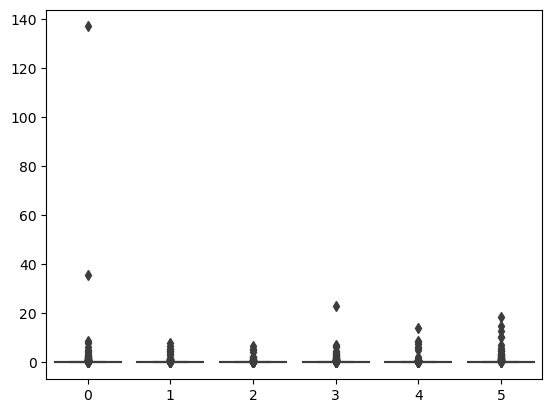

In [229]:
sns.boxplot(np.nanvar(Rji_BS, axis=1))